## A simple swarm

In [8]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [10]:
from core.agent import *
from core.world import * 
from dynamics.space.resource_map import *
from core.render import * 
from core.env_params import * 
from core.skill import * 
from core.models import *
from core.env_params import *
from core.message import *

In [11]:
from dynamics.agents.sar_agent import *
from dynamics.agents.trade_agent import * 
from dynamics.world.sar_world import *
from dynamics.models.util_sampler import *

def initialize_swarm(world : BaseWorld):
    swarm = [SARAgent() for i in range(SWARM_SIZE)]
    # skill_initializer = DefaultSkillInitializer(num_skills = PRODUCT_TYPES)
    utility_initializer = UtilitySampler()

    for agent in swarm:
        # skill_initializer.forward(agent)
        utility_initializer.forward(agent)
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)


In [12]:

from urban.urban_gen import * 
from dynamics.models.victims import * 
from urban.sar_comm import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)
def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)
    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)

    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [13]:
from dynamics.models.energy import EnergyModel
from dynamics.models.victims import VictimModel
world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.add_model("victim_model", VictimModel())
world.reset()

comms_protocol = SARCommunicationProtocol()

In [14]:
# Test movements by doing random actions
def update():
    world.update()
    # Evaluate the agent's utility
    for agent in world.agents:
        agent.utility


    for agent in world.agents:
        agent : SARAgent = agent
        action_choice = np.random.randint(0, 5)
        choice = np.random.randint(1, 5)

        match (action_choice): 
            case 1: agent.move(choice)
            # case 2: agent.pick_up(choice)
            # case 3: agent.put_down(choice)
            # case 4: 
                # prod_to_make = np.random.randint(RESOURCE_TYPES + 1, RESOURCE_TYPES + PRODUCT_TYPES + 1)
                # agent.make(prod_to_make)
            #     pass
    
    comms_protocol.send_messages(world)
    comms_protocol.receive_messages(world)


update()

In [15]:
render_world(world, (800, 800), update_fn=update, delay_s=0)

# Data Visualization

## Social Network 

In [81]:
network = nx.graph.Graph()

for agent in world.agents:
    for neighbor in agent._current_state.relations:
        network.add_edge(agent.id, neighbor, weight = agent._current_state.relations[neighbor])


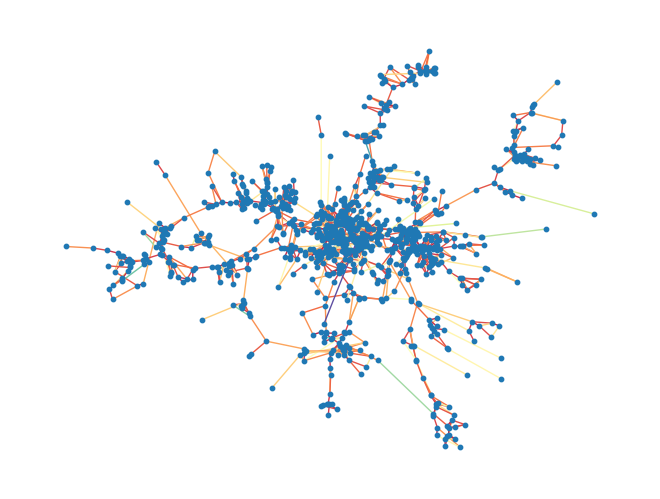

In [82]:
edges,weights = zip(*nx.get_edge_attributes(network ,'weight').items())
nx.draw_kamada_kawai(network, node_size = 10, edge_color = weights, edge_cmap = plt.cm.Spectral)

## Economy

In [ ]:
resources : dict[int, int]  = {}
for agent in world.agents: 
    inventory = agent._current_state.inventory
    for t, q in inventory.items():
        if not t in resources: 
            resources[t] = 0
        resources[t] += q

resource_types = list(resources.keys())
quantities = list(resources.values())

plt.bar(resource_types, quantities)
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.title('Resource Distribution')
plt.show()

## Utility

In [ ]:
utilities = []
for agent in world.agents: 
    utilities.append(agent.utility)


plt.hist(utilities, 50)
plt.title('Agent Happiness')
plt.show()

# Verify certain things about the simulation

In [51]:
swarm = world.agents

In [52]:
# Validate the observation space provided is sensible
obs = swarm[123].local_observation

print(obs.nearby_agents, obs.nearby_agents.shape)

[[  0   0 868   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0 865   0   0   0   0   0]
 [  0   0   0 124   0   0   0]
 [  0   0   0   0   0   0 729]
 [  0   0   0   0   0 596   0]
 [  0   0   0   0 674   0   0]] (7, 7)


In [54]:
# Validate that all observation spaces are square
for agent in swarm: 
    obs = agent.local_observation
    if (obs.nearby_agents.shape[0] != obs.nearby_agents.shape[1]):
        print(agent.id, agent._current_position)

4 [ 0 64]
18 [56  0]
19 [ 2 31]
20 [6 0]
21 [97 50]
25 [98 54]
33 [97 84]
35 [ 0 99]
44 [31  0]
51 [31  1]
65 [78  1]
66 [ 1 38]
67 [63  1]
70 [83 98]
87 [ 1 46]
96 [81 99]
100 [96  0]
126 [51  0]
140 [98 59]
151 [29 99]
192 [45 99]
194 [18  0]
200 [12  0]
203 [54  1]
209 [ 0 54]
214 [ 1 86]
221 [ 0 92]
237 [49  1]
243 [ 2 27]
249 [71  2]
263 [97 98]
268 [88 99]
276 [ 2 64]
277 [99 65]
278 [85 99]
294 [21  0]
310 [60  2]
322 [83  1]
337 [99 20]
346 [15  0]
359 [99  3]
366 [39 99]
371 [56 98]
382 [ 0 22]
389 [98  2]
418 [62  1]
425 [ 0 50]
440 [28 97]
442 [93 97]
449 [39  0]
452 [ 2 35]
461 [43  2]
463 [99 51]
466 [99 74]
474 [ 0 18]
477 [69  2]
479 [29 98]
494 [22  0]
500 [51 99]
504 [53  0]
518 [ 0 32]
529 [17  2]
542 [ 2 44]
556 [97 29]
563 [ 0 35]
567 [ 1 27]
575 [ 0 20]
581 [23  1]
584 [ 0 43]
594 [17 99]
625 [99 72]
626 [ 2 63]
647 [23  0]
651 [3 1]
657 [99  0]
666 [ 0 13]
669 [56 99]
693 [50 99]
694 [75  0]
706 [39  1]
708 [40 99]
713 [58  1]
718 [ 0 59]
723 [99 36]
730 [65 97]
7

In [ ]:
# Validate that all swarm agents landed in different positions
positions = set()
for agent in swarm:
    pos = agent.current_position
    positions.add((pos[0], pos[1]))

print(len(positions), len(world.agents))

In [ ]:
# Check for resources
rsrc_qty = world._resource_map._resource_quantity_map
qtys = []

for i in range(rsrc_qty.shape[0]):
    for j in range(rsrc_qty.shape[1]):
        if rsrc_qty[i, j] > 0:
            qtys.append(rsrc_qty[i, j])

print(qtys)

In [ ]:
# Check for agent state
state = swarm[124]._current_state
print(state.inventory, state.current_utility)


# Perftest

In [287]:
import cProfile
def stress_test():
    np.random.seed(42)
    world.reset()
    for _ in range(0, 1000):
        update()

In [ ]:

cProfile.run('stress_test()', sort = 'time')

In [ ]:
cProfile.run('world.update()', sort = 'time')